In [20]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow_probability.substrates import numpy as tfp
from cmdstanpy import CmdStanModel
import arviz as az

if not os.path.exists('./stan'):
    os.makedirs('./stan')

In [21]:
model_out120 = """

data {
  int<lower=0> N; // Number of observations
  int<lower=0> N_miss; // Number of missing observations
  int<lower=0> P; // Covariate number
  int<lower=0> nyears;
  int<lower=0> nstations;

  array[N] int<lower=0> station;
  array[N] int<lower=0> year;
  array[N] int<lower=0> max_month;

  array[N_miss] int<lower=0> station_miss;
  array[N_miss] int<lower=0> year_miss;
  array[N_miss] int<lower=0> max_month_miss;
  
  array[N] int<lower=0> y; // Count data

  matrix[N, P] X; // Predictor matrix
  matrix[N_miss, P] X_miss; // Predictor matrix

  real phi;
  matrix[nstations, nstations] distances;
}

transformed data {
  matrix[nstations,nstations] H = exp(-(1/phi) * distances);
}

parameters {
  vector[P] beta; // Coefficients for predictors
  vector[nstations] eta; // Random effects for comuni
  vector[nyears] xi; // Random effects for years
  vector[nstations] w; //Random zero-mean effect for the space model
  real<lower = 0> sigma;
  real<lower = 0> sigma0;
}

transformed parameters {
  vector[N] lambda;
  vector[N] fix_eff;
  vector[N] intercept;

  vector[N_miss] lambda_miss;
  vector[N_miss] fix_eff_miss;
  vector[N_miss] intercept_miss;

  matrix[nstations,nstations] Sigma_s = sigma * sigma * H; //To be added the variance
  matrix[nstations,nstations] Lw = cholesky_decompose(Sigma_s);


  fix_eff = X * beta;
  intercept = xi[year] + eta[station] + w[station];

  lambda = exp(fix_eff + intercept);

  fix_eff_miss = X_miss * beta;
  intercept_miss = xi[year_miss] + eta[station_miss] + w[station_miss];

  lambda_miss = exp(fix_eff_miss + intercept_miss);

  /*
  for (i in 1:N) {
    if (lambda[i] > max_month[i]) {
      lambda[i] = max_month[i];
    }
  }

  for (i in 1:N_miss) {
    if (lambda_miss[i] > max_month_miss[i]) {
      lambda_miss[i] = max_month_miss[i];
    }
  }
  */
}

model {
  beta ~ normal(0, 2);
  y[1:N] ~ poisson(lambda[1:N]);

  xi ~ normal(0, 2);
  eta ~ normal(0, sigma0);
  w ~ multi_normal_cholesky(rep_vector(0, nstations), Lw);
  sigma ~ inv_gamma(2, 2);
  sigma0 ~ inv_gamma(2, 2);
}

generated quantities {
  vector[N] log_lik;
  vector[N] y_pred;
  vector[N_miss] y_pred_miss;

  /*
  for (i in 1:N) {
    real sum_p = 0;
    real u = uniform_rng(0, 1);
    for (b in 0:max_month[i]) {
      sum_p = sum_p + exp(poisson_lpmf(b | lambda[i]) - poisson_lcdf(max_month[i] | lambda[i]));
      if (sum_p >= u) {
        y_pred[i] = b;
        break;
      }
    }
  }
  */

  for(i in 1:N){
    log_lik [ i ] = poisson_lpmf (y[i] | lambda[i]);
    y_pred[i] = poisson_rng(lambda[i]);
  }

  for(i in 1:N_miss){
    y_pred_miss[i] = poisson_rng(lambda_miss[i]);
  }
}

"""

stan_file = "./stan/out120.stan"

with open(stan_file, "w") as f:
    print(model_out120, file=f)

model_out120 = CmdStanModel(stan_file=stan_file)

11:54:17 - cmdstanpy - INFO - compiling stan file C:\Users\matte\Desktop\Bayesian_Stat\Bayesian_Project\main\Modello\stan\out120.stan to exe file C:\Users\matte\Desktop\Bayesian_Stat\Bayesian_Project\main\Modello\stan\out120.exe
11:55:29 - cmdstanpy - INFO - compiled model executable: C:\Users\matte\Desktop\Bayesian_Stat\Bayesian_Project\main\Modello\stan\out120.exe


In [22]:
X = pd.read_csv("../Datasets/covariates.csv")
Y = pd.read_csv("../Datasets/Dataset_120.csv")

Y.loc[:,'Count_120'] = pd.to_numeric(Y['Count_120']).astype('Int64')
X = pd.get_dummies(X ,columns = ['Type'] ,prefix = 'type', drop_first = True)
X.loc[X['Station'] == 10171, 'Quota'] = 10

phi = 62/3
distances = pd.read_csv("../Datasets/distances.csv", index_col=0)

In [23]:
rows_to_drop_Y = Y[Y['Count_120'].isna()].index

# Remove corresponding rows from dataset X
X_obs = X.drop(index=rows_to_drop_Y)
Y_obs = Y.drop(index=rows_to_drop_Y)
X_miss = X.loc[rows_to_drop_Y,:]
Y_miss = Y.loc[rows_to_drop_Y,:]

#saving the indexes of the dataframes
X_obs_index = X_obs.index
Y_obs_index = Y_obs.index
X_miss_index = X_miss.index
Y_miss_index = Y_miss.index

# If you want to reset the index after dropping rows
X_obs = X_obs.reset_index(drop=True)
Y_obs = Y_obs.reset_index(drop=True)
X_miss = X_miss.reset_index(drop=True)
Y_miss = Y_miss.reset_index(drop=True)

In [24]:
stations_obs = X_obs.loc[:,'Station']
years_raw_obs = X_obs.loc[:,'Year']
months_raw_obs = X_obs.loc[:,'Month']
years_obs = X_obs.loc[:,'Year'] - 2009
unique_values_obs = sorted(set(stations_obs))
mapping_dict_obs = {value: index + 1 for index, value in enumerate(unique_values_obs)}
transformed_stations_obs = [mapping_dict_obs[value] for value in stations_obs]

transformed_stations_obs = pd.Series(transformed_stations_obs)
years_obs = pd.Series(years_obs)

stations_miss = X_miss.loc[:,'Station']
years_raw_miss = X_miss.loc[:,'Year']
months_raw_miss = X_miss.loc[:,'Month']
years_miss = X_miss.loc[:,'Year'] - 2009
unique_values_miss = sorted(set(stations_miss))
mapping_dict_miss = {value_miss: index_miss + 1 for index_miss, value_miss in enumerate(unique_values_miss)}
transformed_stations_miss = [mapping_dict_miss[value_miss] for value_miss in stations_miss]

transformed_stations_miss = pd.Series(transformed_stations_miss)
years_miss = pd.Series(years_miss)

day_in_month = [31,28,31,30,31,30,31,31,30,31,30,31]

max_month_obs = []
max_month_miss = []

for i in range(0,X_obs.shape[0]):
    max_month_obs.append(day_in_month[X_obs['Month'][i]-1])

for i in range(0,X_miss.shape[0]):
    max_month_miss.append(day_in_month[X_miss['Month'][i]-1])

max_month_obs = pd.Series(max_month_obs)
max_month_miss = pd.Series(max_month_miss)

In [25]:
X_obs = X_obs.drop(['Year','Station','Month'], axis  = 1)
X_miss = X_miss.drop(['Year','Station','Month'], axis  = 1)

In [26]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_obs_std = scaler.fit_transform(X_obs)
X_obs_std = pd.DataFrame(X_obs_std, columns=X_obs.columns)
X_obs_std.loc[:,"type_rural"] = X.loc[:,"type_rural"]
X_obs_std.loc[:,"type_urban"] = X.loc[:,"type_urban"]
X_obs_std.loc[:,"type_rural"] = pd.to_numeric(X_obs_std.loc[:,"type_rural"]).astype('Int64')
X_obs_std.loc[:,"type_urban"] = pd.to_numeric(X_obs_std.loc[:,"type_urban"]).astype('Int64')

X_miss_std = scaler.fit_transform(X_miss)
X_miss_std = pd.DataFrame(X_miss_std, columns=X_miss.columns)
X_miss_std.loc[:,"type_rural"] = X_miss.loc[:,"type_rural"]
X_miss_std.loc[:,"type_urban"] = X_miss.loc[:,"type_urban"]
X_miss_std.loc[:,"type_rural"] = pd.to_numeric(X_miss_std.loc[:,"type_rural"]).astype('Int64')
X_miss_std.loc[:,"type_urban"] = pd.to_numeric(X_miss_std.loc[:,"type_urban"]).astype('Int64')

In [27]:
data_out120 = {
    "N": len(Y_obs),
    "N_miss": len(Y_miss),
    "P": X_obs_std.shape[1],
    "nyears": 13,
    "nstations": 45,
    "station": transformed_stations_obs,
    "year": years_obs,
    "max_month": max_month_obs,
    "station_miss": transformed_stations_miss,
    "year_miss": years_miss,
    "max_month_miss": max_month_miss,
    "y": Y_obs['Count_120'],
    "X_miss": X_miss_std,
    "X": X_obs_std,
    "phi": phi,
    "distances": distances
}

fit_out120 = model_out120.sample(data=data_out120, chains=4, parallel_chains=4, 
    iter_warmup=500, iter_sampling=500)
posterior_out120 = az.from_cmdstanpy(fit_out120)

11:55:30 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▊         | 00:00 Status


chain 1 |█▋        | 00:26 Iteration:   1 / 1000 [  0%]  (Warmup)


chain 1 |██▌       | 00:41 Iteration: 100 / 1000 [ 10%]  (Warmup)


chain 1 |███▎      | 00:53 Iteration: 200 / 1000 [ 20%]  (Warmup)


chain 1 |████▏     | 01:03 Iteration: 300 / 1000 [ 30%]  (Warmup)


chain 1 |█████▊    | 01:16 Iteration: 500 / 1000 [ 50%]  (Warmup)


chain 1 |██████▋   | 01:34 Iteration: 501 / 1000 [ 50%]  (Sampling)


chain 1 |███████▌  | 01:51 Iteration: 600 / 1000 [ 60%]  (Sampling)



chain 1 |████████▎ | 02:06 Iteration: 700 / 1000 [ 70%]  (Sampling)


chain 1 |█████████▏| 02:21 Iteration: 800 / 1000 [ 80%]  (Sampling)




chain 1 |██████████| 02:33 Sampling completed                      
chain 2 |██████████| 02:33 Sampling completed                      
chain 3 |██████████| 02:33 Sampling completed                      
chain 4 |██████████| 02:33 Sampling completed 


11:58:04 - cmdstanpy - INFO - CmdStan done processing.
11:58:04 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'out120.stan', line 50, column 2 to column 63)
	Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'out120.stan', line 50, column 2 to column 63)
	Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'out120.stan', line 50, column 2 to column 63)
	Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'out120.stan', line 50, column 2 to column 63)
Exception: cholesky_decompose: Matrix m is not positive definite (in 'out120.stan', line 50, column 2 to column 63)
Exception: cholesky_decompose: Matrix m is not positive definite (in 'out120.stan', line 50, column 2 to column 63)
Exception: cholesky_decompose: Matrix m is not positive definite (in 'out120.stan', line 50, column 2 to column

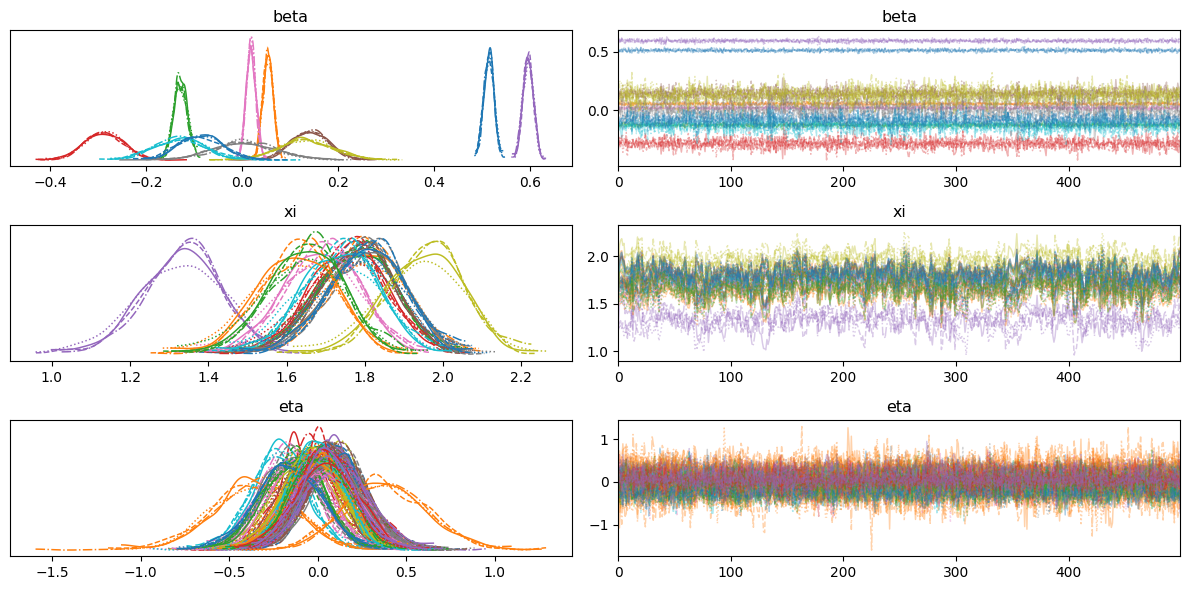

In [28]:
az.plot_trace(posterior_out120, var_names=['beta', 'xi', 'eta'], compact=True)
plt.tight_layout()
plt.show()

In [29]:
posterior_out120

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats

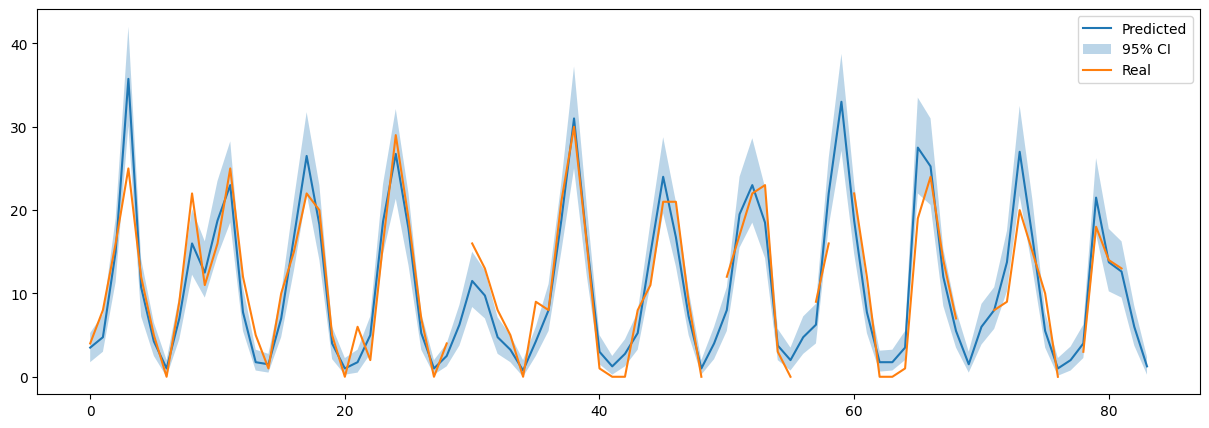

In [30]:
preds_y = posterior_out120['posterior']['y_pred'].mean(axis=0)
preds_y_miss = posterior_out120['posterior']['y_pred_miss'].mean(axis=0)

y_star = preds_y.median(axis=0)
y_star_up = np.percentile(preds_y, 97.5, axis=0)
y_star_low = np.percentile(preds_y, 2.5, axis=0)

y_star_miss = preds_y_miss.median(axis=0)
y_star_up_miss = np.percentile(preds_y_miss, 97.5, axis=0)
y_star_low_miss = np.percentile(preds_y_miss, 2.5, axis=0)

# Recunstruct the original indexes
y_star_obs = pd.Series(y_star, index=Y_obs_index)
y_star_up_obs = pd.Series(y_star_up, index=Y_obs_index)
y_star_low_obs = pd.Series(y_star_low, index=Y_obs_index)

y_star_miss = pd.Series(y_star_miss, index=Y_miss_index)
y_star_up_miss = pd.Series(y_star_up_miss, index=Y_miss_index)
y_star_low_miss = pd.Series(y_star_low_miss, index=Y_miss_index)

# Add the missing values
y_star_total = pd.concat([y_star_obs, y_star_miss])
y_star_up_total = pd.concat([y_star_up_obs, y_star_up_miss])
y_star_low_total = pd.concat([y_star_low_obs, y_star_low_miss])

# Sort the values
y_star_total = y_star_total.sort_index()
y_star_up_total = y_star_up_total.sort_index()
y_star_low_total = y_star_low_total.sort_index()

# Plot the predictions with the real values skipping the plot of the NA values
Y_data = np.array(Y['Count_120'])
Y_data[rows_to_drop_Y] = np.nan
station_num_to_plot = 1 # Change this to plot a different station, -1 to plot manually
if station_num_to_plot != -1:
    xx = np.arange(12*7*(station_num_to_plot-1), 12*7*station_num_to_plot)
else:
    xx = np.arange(1000, 1200) # Change this for the range of the manual choice
plt.figure(figsize=(15, 5))
plt.plot(xx, y_star_total[xx], label='Predicted')
plt.fill_between(xx, y_star_low_total[xx], y_star_up_total[xx], alpha=0.3, label='95% CI')
plt.plot(xx, Y_data[xx], label='Real')
plt.legend()
plt.show()


In [31]:
# We identify the outliers using the 95% confidence interval
outliers = np.where((y_star_low > Y_obs['Count_120']) | (y_star_up < Y_obs['Count_120']))[0]
print(outliers)
print(outliers.shape)

[   1    3    8 ... 3832 3837 3839]
(1916,)


[   3   79  409  591  625  646  674  867  913 1086 1121 1170 1177 1353
 1387 1435 1533 1616 1919 1965 2091 2139 2175 2312 2387 2599 2620 2648
 2655 2667 2686 2699 2700 2707 2713 2714 2734 2735 2906 2913 2996 3022
 3035 3084 3122 3341 3376 3396 3423 3545 3591 3629 3757 3788]
(54,)
[   3  391  410  422  429  478  513  585  599  674  695  701  769  770
  876  884  920  950 1016 1021 1032 1222 1407 1408 1527 1540 1889 1983
 2026 2119 2140 2221 2251 2399 2580 2613 2648 2655 2663 2699 2700 2718
 2734 2735 2749 2761 2832 2833 2839 2920 3014 3028 3042 3095 3140 3161
 3423 3430 3522 3526 3607 3608 3694]
(63,)


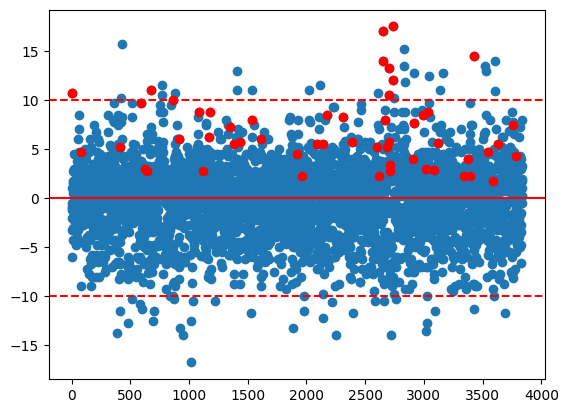

In [32]:
idx_over_max = np.where(y_star > max_month_obs)[0]
print(idx_over_max)
print(idx_over_max.shape)

res = y_star - Y_obs['Count_120']
residuals = np.abs(res)

res_over_10 = np.where(residuals > 10)[0]
print(res_over_10)
print(res_over_10.shape)

#plot these residuals
plt.scatter(np.arange(0, len(res)),res)
plt.scatter(idx_over_max, res[idx_over_max], color='r')
plt.axhline(y=0, color='r', linestyle='-')
plt.axhline(y=10, color='r', linestyle='--')
plt.axhline(y=-10, color='r', linestyle='--')
plt.show()

In [33]:
mae = np.mean(residuals)
print(mae)
mse = np.mean(residuals**2)
print(mse)

<xarray.DataArray ()>
array(2.81292318)
<xarray.DataArray ()>
array(13.90661214)


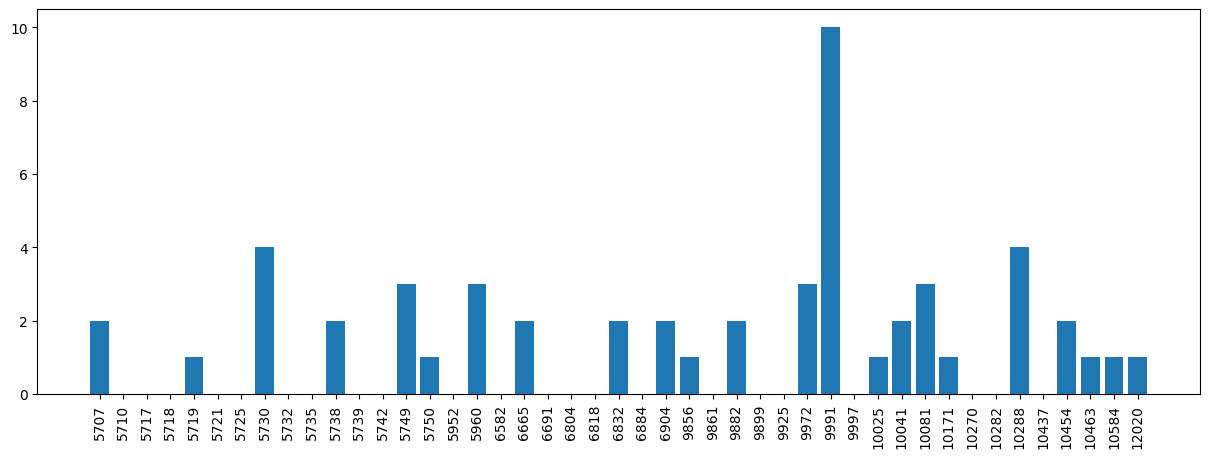

In [34]:
# Count how many outliers we have per station
outliers_per_station = pd.Series(np.zeros(45), index=stations_obs.unique())
for i in idx_over_max:
    outliers_per_station[stations_obs[i]] += 1
outliers_per_station = outliers_per_station.astype(int)
outliers_per_station.index = outliers_per_station.index.astype(str)

plt.figure(figsize=(15, 5))
plt.bar(outliers_per_station.index, outliers_per_station)
plt.xticks(rotation=90)
plt.show()

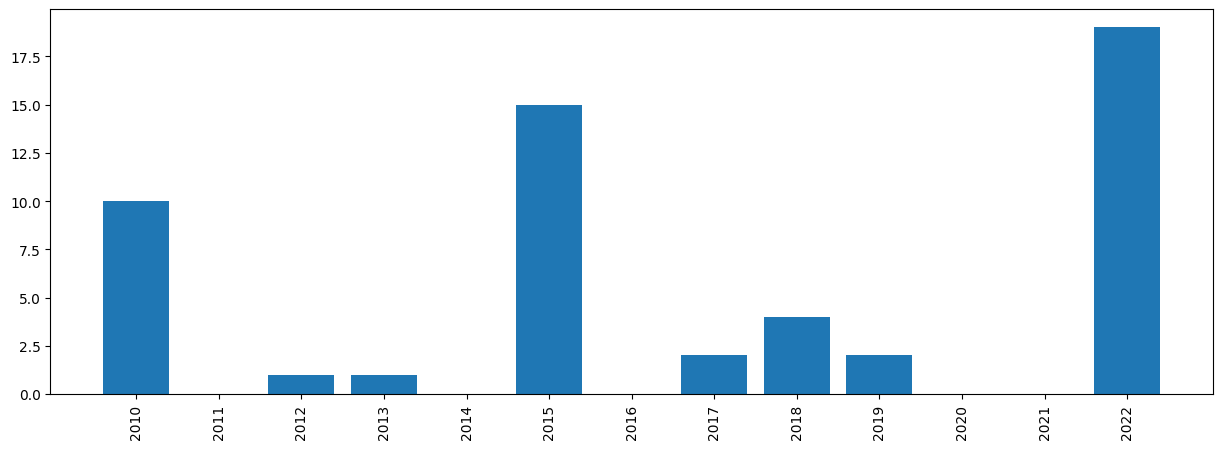

In [35]:
# Count how many outliers we have per year
outliers_per_year = pd.Series(np.zeros(13), index=years_raw_obs.unique())
for i in idx_over_max:
    outliers_per_year[years_raw_obs[i]] += 1
outliers_per_year = outliers_per_year.astype(int)
outliers_per_year.index = outliers_per_year.index.astype(str)

plt.figure(figsize=(15, 5))
plt.bar(outliers_per_year.index, outliers_per_year)
plt.xticks(rotation=90)
plt.show()

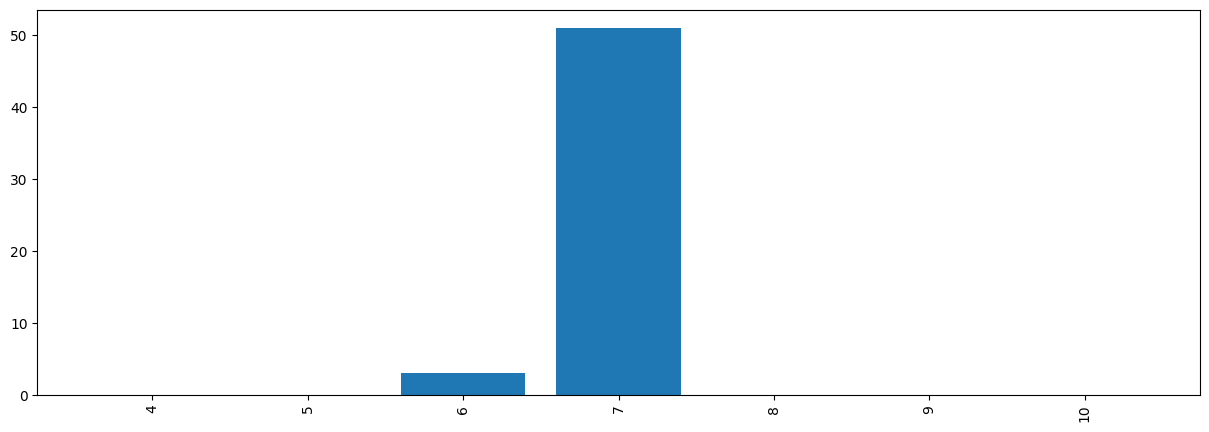

In [36]:
# Count how many outliers we have per month
outliers_per_month = pd.Series(np.zeros(7), index=months_raw_obs.unique())
for i in idx_over_max:
    outliers_per_month[months_raw_obs[i]] += 1
outliers_per_month = outliers_per_month.astype(int)
outliers_per_month.index = outliers_per_month.index.astype(str)

plt.figure(figsize=(15, 5))
plt.bar(outliers_per_month.index, outliers_per_month)
plt.xticks(rotation=90)
plt.show()

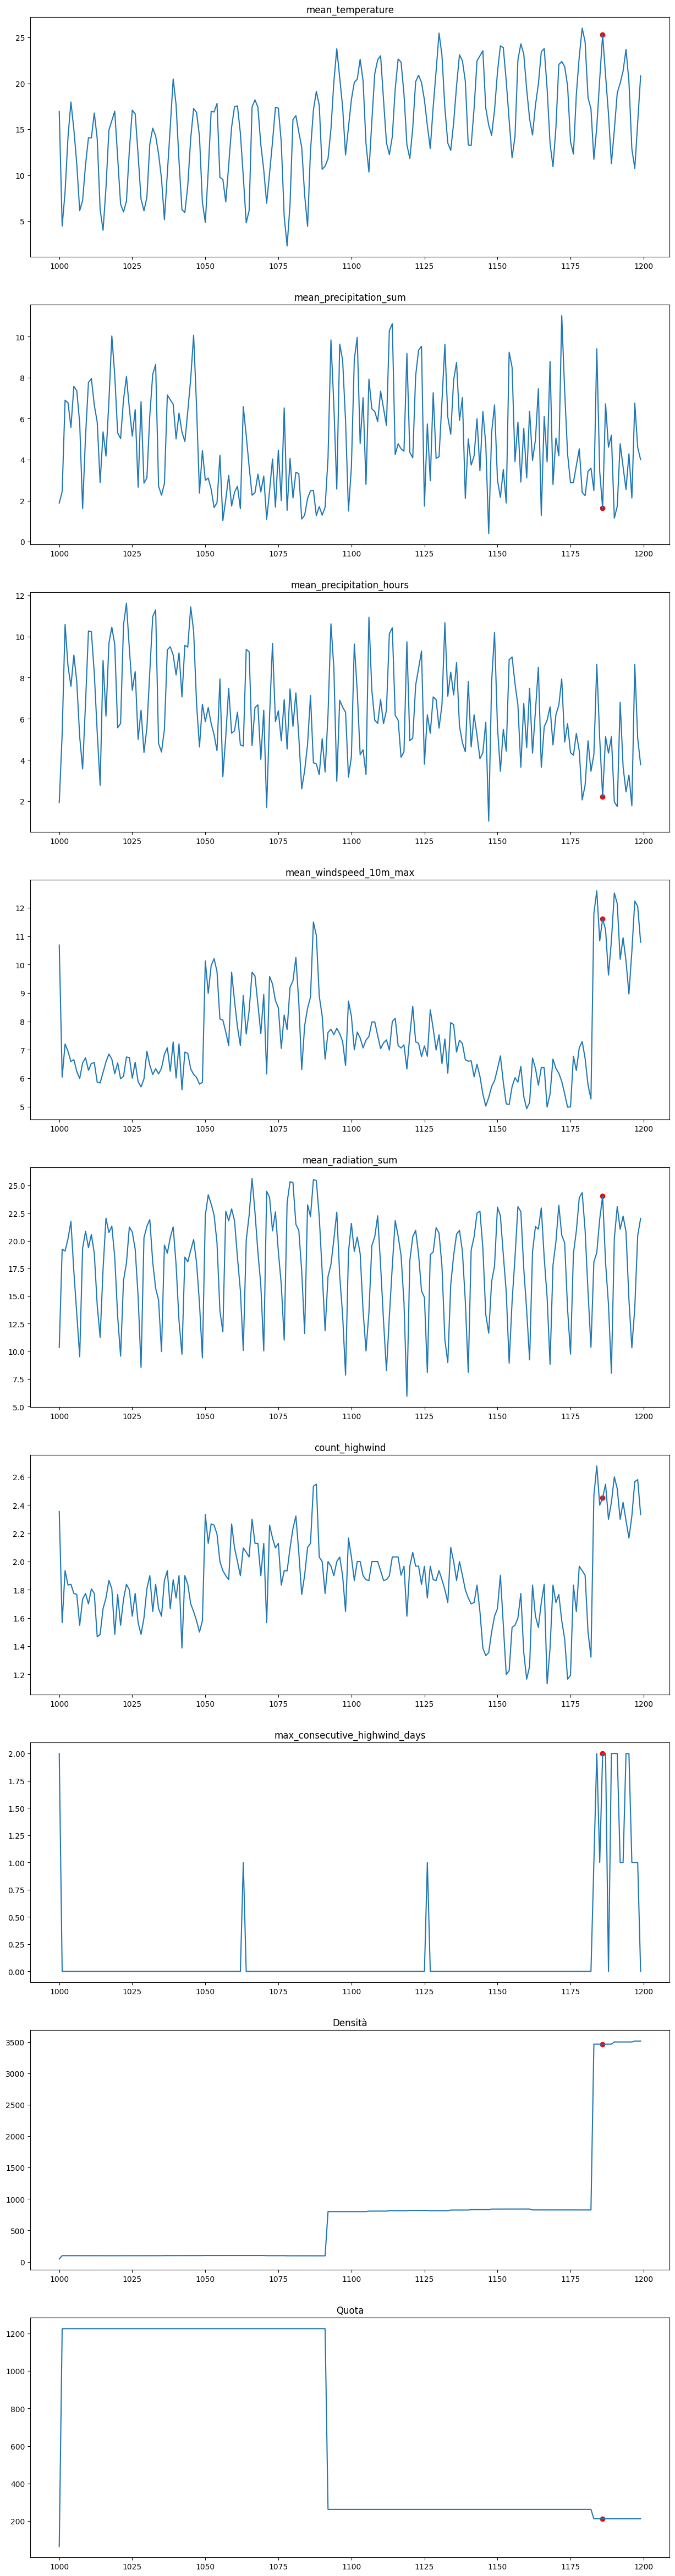

In [37]:
# Plotting covariates around the outliers
X_data = X.drop(['Year','Station','Month'], axis  = 1)
station_num_to_plot = -1 # Change this to plot different stations, -1 to choose manually
if station_num_to_plot != -1:
    xx = np.arange(12*7*(station_num_to_plot-1), 12*7*station_num_to_plot)
else:
    xx = np.arange(1000, 1200) # Change this for the range of the manual choice
fig, axs = plt.subplots(9, 1, figsize=(15, 60))
for i in range(0,9):
    axs[i].plot(xx, X_data.iloc[:,i][xx])
    axs[i].scatter(np.intersect1d(X_obs_index[idx_over_max],xx), X_data.iloc[:,i][np.intersect1d(X_obs_index[idx_over_max],xx)], color='r')
    axs[i].set_title(X_data.columns[i])
plt.show()